In [3]:
import numpy as np
import pandas as pd
import os
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
import hdbscan
DATA_DIR = 'data/'

In [2]:
#Reading data 

folder = 'data/chunks/'
all_chunks = pd.DataFrame()
# all_labels = pd.DataFrame()
for entry in os.scandir(folder):
    with open(entry.path, 'rb') as chunkf:
        chunk_df = pickle.load(chunkf)
        all_chunks = pd.concat([all_chunks, chunk_df])
       
print('Original data', all_chunks.shape)

Original data (19999, 33)


In [7]:
#Label encoding - converting columns with non-numeric datatypes to numeric 

from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel


all_chunks=all_chunks.dropna(subset=['song_hotttnesss'])
print(all_chunks.shape)

le = LabelEncoder()
for column in all_chunks.columns:
    if(all_chunks[column].dtype=='object'):
        all_chunks[column] = le.fit_transform(all_chunks[column])

(11692, 33)


In [8]:
X=all_chunks[['artist_familiarity',
       'artist_hotttnesss', 'artist_id','duration', 'end_of_fade_in', 'energy', 'key_confidence','key', 
              'loudness', 'mode', 'mode_confidence',
       'start_of_fade_out', 'tempo','time_signature_confidence']]

In [12]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=100)
cluster_labels = clusterer.fit_predict(X)

In [13]:
cluster_labels

array([ 1, -1, -1, ...,  1,  1,  1], dtype=int64)

(array([3574.,    0.,    0.,    0.,    0.,  964.,    0.,    0.,    0.,
        7154.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

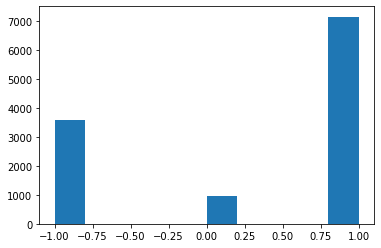

In [14]:
plt.hist(cluster_labels)

In [137]:
with open(DATA_DIR+"complete_data.pkl","rb") as f:
    datal=pickle.load(f)

print(datal.shape)

(49658, 336)


In [138]:
# datal
# ['tempo',
#       'artist_familiarity', 
#       'mode', 'loudness', 
#       'artist_hotttnesss', 
#       'key_confidence', 
#       'end_of_fade_in', 
#       'start_of_fade_out', 
#       'duration', 
#       'time_signature', 
#       'key', 
#       'song_hotttnesss',
#       'genre']
kept_cols = ['tempo',
      'artist_familiarity', 
      'mode', 'loudness', 
      'artist_hotttnesss', 
      'key_confidence', 
      'end_of_fade_in', 
      'start_of_fade_out', 
      'duration', 
      'time_signature', 
      'key', 
      'song_hotttnesss',
      'genre']
print(datal.shape)
msd_cols = datal.columns[:36]
for i in msd_cols:
    if i not in kept_cols:
        datal.drop(i, inplace=True, axis=1)
        
print(datal.shape)
datal.dropna(inplace=True)
print(datal.shape)

(49658, 336)
(49658, 313)
(34294, 313)
0        0.516346
1        0.826612
2        0.702800
3        0.604205
4        0.651125
           ...   
49650    0.000000
49653    0.659300
49655    0.000000
49656    0.533371
49657    0.519449
Name: song_hotttnesss, Length: 34294, dtype: float64


In [139]:
#Label encoding - converting columns with non-numeric datatypes to numeric 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for column in datal.columns:
    if(datal[column].dtype=='object'):
        print("Transforming column: ", column)
        datal[column] = le.fit_transform(datal[column])
print(datal.shape)

Transforming column:  genre
(34294, 313)


In [141]:
from sklearn import preprocessing
# print('hotttness',datal[11])
x = datal.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
datal = pd.DataFrame(x_scaled)
datal.columns

RangeIndex(start=0, stop=313, step=1)

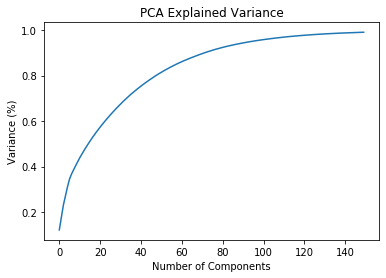

In [142]:
# pca waiting for final pkl
from sklearn.decomposition import PCA

pca = PCA().fit(datal)
plt.figure()

plt.plot(np.cumsum(pca.explained_variance_ratio_[:150]))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('PCA Explained Variance')
plt.ion()
plt.show()


In [143]:
cum_sum = np.cumsum(pca.explained_variance_ratio_)
comps_num = int(np.argmax(cum_sum>=.988))
comps_num

142

In [144]:
# dimensionality reduction
pca = PCA(n_components=comps_num)
dataf_red=pd.DataFrame(pca.fit_transform(datal))
dataf_red.shape

(34294, 142)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


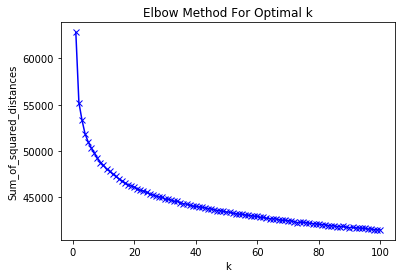

In [149]:
from sklearn.cluster import KMeans 
step_size=100

Sum_of_squared_distances = []
K = range(1,101)
for k in K:
    print(k)
    km = KMeans(n_clusters=k)
    km = km.fit(dataf_red)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [150]:

for k in range(101, 150):
    km = KMeans(n_clusters=k)
    km = km.fit(dataf_red)
    Sum_of_squared_distances.append(km.inertia_)

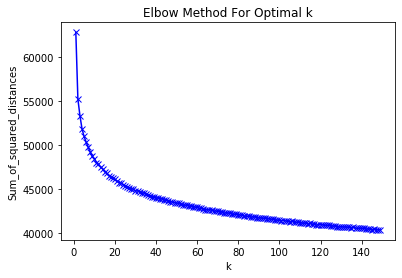

In [152]:
plt.plot(range(1,150), Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

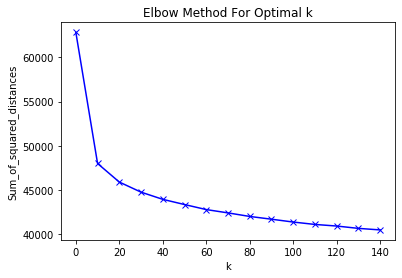

In [157]:
plt.plot(range(0,150,10), Sum_of_squared_distances[::10], 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [158]:
for k in range(150, 500):
    km = KMeans(n_clusters=k)
    km = km.fit(dataf_red)
    Sum_of_squared_distances.append(km.inertia_)

KeyboardInterrupt: 

In [159]:
print(len(Sum_of_squared_distances))

464


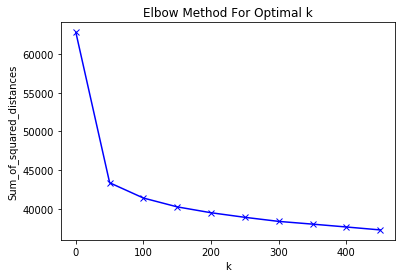

In [162]:
plt.plot(range(0,464,50), Sum_of_squared_distances[::50], 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [163]:
for k in range(465, 500):
    km = KMeans(n_clusters=k)
    km = km.fit(dataf_red)
    Sum_of_squared_distances.append(km.inertia_)

KeyboardInterrupt: 

In [164]:
print(len(Sum_of_squared_distances))

474


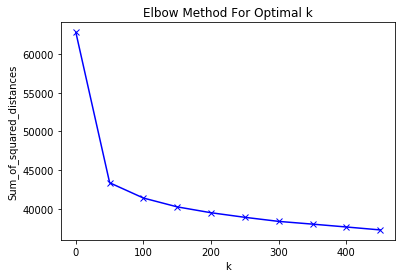

In [165]:
plt.plot(range(0,464,50), Sum_of_squared_distances[::50], 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [166]:
for k in range(474, 500):
    km = KMeans(n_clusters=k)
    km = km.fit(dataf_red)
    Sum_of_squared_distances.append(km.inertia_)

KeyboardInterrupt: 

In [167]:
print(len(Sum_of_squared_distances))

479


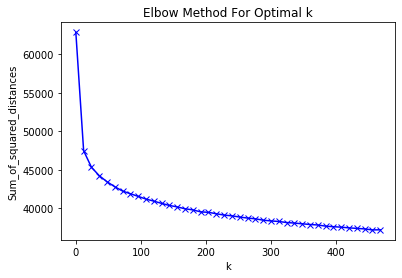

In [173]:
plt.plot(range(0,479,12), Sum_of_squared_distances[::12], 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [225]:
kmeans=KMeans(n_clusters=12,random_state=0).fit(dataf_red)

with open(DATA_DIR+"kmeans_2.pkl","wb") as f:
    pickle.dump(kmeans,f)

In [226]:
# plot
# plot 3 most important components
y_kmeans = kmeans.predict(X)
print(y_kmeans.shape)
dataf_red[141].shape

(34294,)


(34294,)

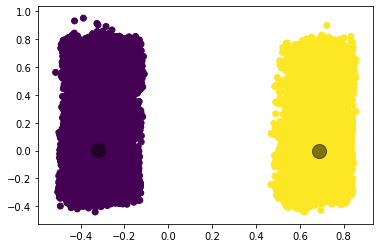

In [205]:
plt.scatter(dataf_red[0], dataf_red[1], c=y_kmeans)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

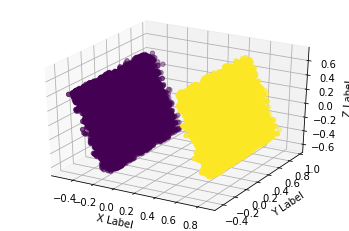

In [206]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(dataf_red[0], dataf_red[1], dataf_red[2], c=y_kmeans, marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


In [214]:
with open(DATA_DIR+"complete_data.pkl","rb") as f:
    datal2=pickle.load(f)

kept_cols = ['tempo',
  'artist_familiarity', 
  'mode', 'loudness', 
  'artist_hotttnesss', 
  'key_confidence', 
  'end_of_fade_in', 
  'start_of_fade_out', 
  'duration', 
  'time_signature', 
  'key', 
  'song_hotttnesss',
  'genre']
print(datal2.shape)
msd_cols = datal2.columns[:36]
for i in msd_cols:
    if i not in kept_cols:
        datal2.drop(i, inplace=True, axis=1)
        
print(datal2.shape)
datal2.dropna(inplace=True)
print(datal2.shape)

(49658, 336)
(49658, 313)
(34294, 313)


In [216]:
datal2['genre']
#Label encoding - converting columns with non-numeric datatypes to numeric 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for column in datal2.columns:
    if(datal2[column].dtype=='object'):
        print("Transforming column: ", column)
        datal2[column] = le.fit_transform(datal2[column])
print(datal2.shape)

Transforming column:  genre
(34294, 313)


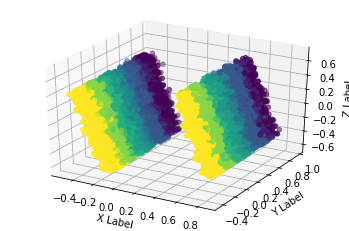

In [217]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(dataf_red[0], dataf_red[1], dataf_red[2], c=datal2['genre'], marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

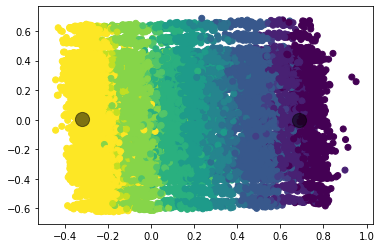

In [218]:
plt.scatter(dataf_red[1], dataf_red[2], c=datal2['genre'])

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

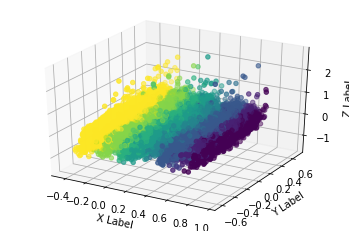

In [219]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(dataf_red[1], dataf_red[2], dataf_red[3], c=datal2['genre'], marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [221]:
np.unique(datal2['genre'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [223]:
y_kmeans[:20]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
      dtype=int32)

In [224]:
datal2['lyrics']

KeyError: 'lyrics'